# Response calculations

In [1]:
from scipy.constants import h, pi
import pandas as pd
from physics.mkid import noroozian
from notebooks.library import display
display.hide_code()

In [2]:
def common(df, key):
    s = set(df[key])
    if len(s) > 1:
        raise ValueError("Multiple values for {}".format(key))
    else:
        return s.pop()

In [3]:
noise_colormap = plt.cm.RdYlBu_r
cw_color = 'saddlebrown' #'darkgoldenrod'
bb_color = 'darkgreen'
cw_marker = 's'
bb_marker = 'o'
cw_label = "continuous-wave"
bb_label = "broadband"

Sx_scale = 1e18
noise_ylimits = (Sx_scale * 1e-19, Sx_scale * 3e-15)
noise_xlimits = (1e1, 1e4)

PA_scale = 1e12
X_scale = 1e6
PA_limits = (8e-4, 6e1)
X_limits = (1e-1, 1e3)
NEPA_limits = (1e-18, 1e-15)
PA_line = np.logspace(np.log10(PA_limits[0]), np.log10(PA_limits[1]), 1e3) / PA_scale
to_aWrtHz = 1e18

In [4]:
cw = pd.DataFrame(np.load('continuous-wave.npy'))
bb = pd.DataFrame(np.load('broadband.npy'))

In [5]:
cw_max_name = 'cw20_ampfreebincut10prop'
cw_max_short = 'afbc10p'
bb_max_name = 'bb20_ampfreebincut10prop'
bb_max_short = 'afbc10p'

In [6]:
eta_cw = common(cw, 'eta')
eta_bb = common(bb, 'eta')
nu_cw = common(cw, 'timestream_mmw_source_freq')
nu_bb = 150e9

In [7]:
# Calculate the time constant from the fit parameter:
cw['tau'] = 1 / (2 * pi * cw['{}_invtau'.format(cw_max_name)])
cw['tau_r'] = cw.Q / (pi * 1e6 * cw.f_r)
bb['tau'] = 1 / (2 * pi * bb['{}_invtau'.format(bb_max_name)])
bb['tau_r'] = bb.Q / (pi * 1e6 * bb.f_r)

Start with the rate equation for the quasiparticle number:
$\mathrm{d} N_{qp} / \mathrm{d} t = \Gamma - \Gamma_R$,
with recombination rate

\begin{equation*}
\Gamma_R
  =
  \frac{N_{qp}^2}{2 N_* \tau_\mathrm{max}} + \frac{N_{qp}}{\tau_\mathrm{max}}.
\end{equation*}

Let the generation rate $\Gamma = \Gamma_0 + \Gamma_S$, where $\Gamma_0$ is the due to the constant background and $\Gamma_S$ is due to the millimeter-wave source. Take $N_*$ and $\tau_\mathrm{max}$ to describe saturation of the relaxation time at very low quasiparticle density due to some physics other than recombination with phonon emission. (I think this implies that we can't measure $N_*$ and $\tau_\mathrm{max}$ separately, only their product.) As in the paper, assume that $N_*$ is negligible since we seem to be limited by background loading. Then, $\Gamma_R = N_{qp}^2 / 2 N_* \tau_\mathrm{max}$, so the rate equation is

\begin{equation*}
\frac{\mathrm{d} N_{qp}}{\mathrm{d} t}
  =
  \Gamma - \Gamma_R
  =
  \Gamma_0 + \Gamma_S - \frac{N_{qp}^2}{2 N_* \tau_\mathrm{max}}.
\end{equation*}

In steady state we have $\Gamma = \Gamma_R$ and

\begin{equation*}
N_{qp}(\Gamma)
  =
  \left( 2 \tau_\mathrm{max} N_* \Gamma \right)^{1/2}
  =
  \left( N_{qp, 0}^2 + 2 N_* \tau_\mathrm{max} \Gamma_S \right)^{1/2},
\end{equation*}

where $N_{qp, 0} = (2 N_* \tau_\mathrm{max} \Gamma_0)^{1/2}$ is the quasiparticle number with the source off. 

Assume that the fractional frequency shift from the (inaccessible) zero-temperature state is $x = X N_{qp}$, where $X$ is constant. What we actually measure is $\hat{x} = X(N_{qp} - N_{qp, 0})$, which seems to give the same result as using $N_*$ in place of $N_{qp, 0}$.

We can now calculate the expected responsivity:

\begin{align*}
\frac{\mathrm{d} x}{\mathrm{d} P_S}
  &=
  \frac{\mathrm{d} x}{\mathrm{d} N_{qp}}
  \frac{\mathrm{d} N_{qp}}{\mathrm{d} \Gamma_S}
  \frac{\mathrm{d} \Gamma_S}{\mathrm{d} P_A}
  \frac{\mathrm{d} P_A}{\mathrm{d} P_S} \\
  &=
  (X)
  (2 N_{qp} [2 N_* \tau_\mathrm{max}] )^{-1}
  (2 / h \nu) (\eta_S) \\
  &=
  \frac{2 \eta_S X \tau_{qp}}{h \nu},
\end{align*}

using
$
(2 N_{qp} [2 N_* \tau_{\mathrm{max}}])^{-1}
  =
  (2 N_{qp})^{-1} (N_{qp}^2 / \Gamma)
  =
  N_{qp} / 2 \Gamma
  =
  \tau_{qp}.
$
In principle, we know all of these quantities. 

At the lowest source power, the value of $\tau_{fit}$ measured from the noise fit is a little more than twice the calculated $\tau_{ring} = Q_r / \pi f_r$. See below.

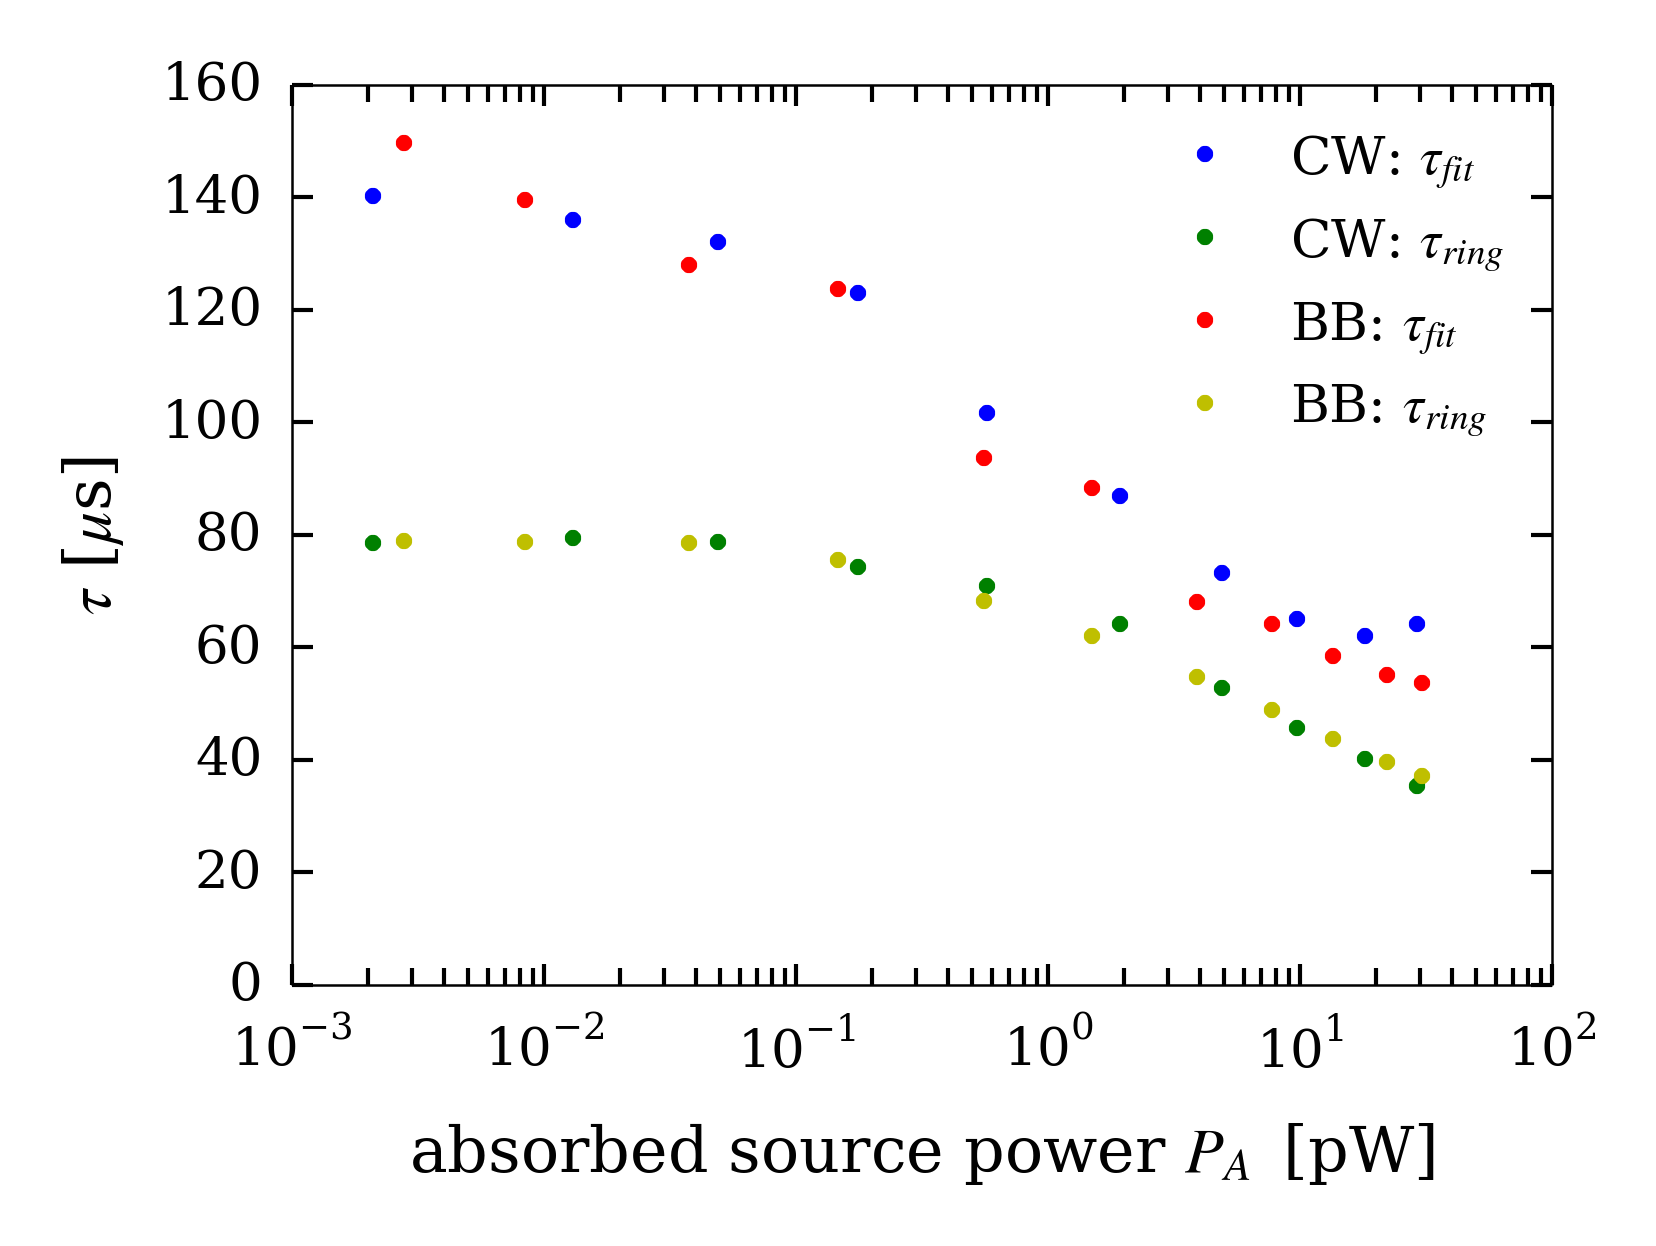

In [8]:
fig, ax = plt.subplots()
ax.semilogx(PA_scale * eta_cw * cw.source_power, 1e6 * cw.tau,
            '.b', label=r'CW: $\tau_{fit}$')
ax.semilogx(PA_scale * eta_cw * cw.source_power, 1e6 * cw.tau_r,
            '.g', label=r'CW: $\tau_{ring}$')
ax.semilogx(PA_scale * eta_bb * bb.source_power, 1e6 * bb.tau,
            '.r', label=r'BB: $\tau_{fit}$')
ax.semilogx(PA_scale * eta_bb * bb.source_power, 1e6 * bb.tau_r,
            '.y', label=r'BB: $\tau_{ring}$')

ax.legend(loc='best')
ax.set_xlabel(r'absorbed source power $P_A$ [pW]')
ax.set_ylabel(r'$\tau$ [$\mu$s]')
ax.set_ylim(0, 160);

#### Figure 1. The time constant extracted from Lorentzian fits to the noise roll-off is $\tau_{fit}$, while $\tau_{ring} = Q_r / \pi f_r$ is the resonator ring-down time.

It looks like the measured time constant is somewhat higher than the ring-down time, so let's use $\tau_{fit}$ as an upper bound on $\tau_{qp}$. At the lowest source power,

In [30]:
cw['tau_qp0'] = cw['tau'].max()
bb['tau_qp0'] = bb['tau'].max()
print("tau_qp0 = {:.0f} us".format(1e6 * common(cw, 'tau_qp0')))

tau_qp0 = 140 us


Take the absorbed background power to be $P_0 = 0.08$ pW, as obtained from the apparent saturation of the NEP. Then, the background generation rate is $\Gamma_0 = 2 P_0 / h \nu$:

In [28]:
P_0 = 0.08e-12  # from 2 K black body calculation
cw['Gamma_0'] = 2 * P_0 / (h * nu_cw)
bb['Gamma_0'] = 2 * P_0 / (h * nu_bb)
print("Gamma_0 = {:.3g} s^(-1)".format(common(cw, 'Gamma_0')))

Gamma_0 = 1.63e+09 s^(-1)


Combining these gives $N_{qp, 0} = 2 \tau_{qp, 0} \Gamma_0$:

In [31]:
cw['N_qp0'] = 2 * cw['tau'].max() * cw.Gamma_0
bb['N_qp0'] = 2 * bb['tau'].max() * bb.Gamma_0
print("N_qp0 = {:.3g}".format(common(cw, 'N_qp0')))

N_qp0 = 4.58e+05


We can also calculate the product $N_* \tau_\mathrm{max} = N_{qp, 0} \tau_{qp, 0}$:

In [32]:
cw['N_star_tau_max'] = cw.N_qp0 * cw.tau_qp0
bb['N_star_tau_max'] = bb.N_qp0 * bb.tau_qp0
print("N_star tau_max = {:.3g} s".format(common(cw, 'N_star_tau_max')))

N_star tau_max = 64.2 s


In [34]:
T = 0.120  # Bath temp
T_c = 1.3  # K
Delta = noroozian.BCS_Delta_0(T_c)
cw['S_2'] = noroozian.S_2(np.array(cw.f_r), T, Delta)
bb['S_2'] = noroozian.S_2(np.array(bb.f_r), T, Delta)

Use
$$
x = X N_{qp} = \frac{S_2(f, T, \Delta) N_{qp}}{4 N_0 \Delta V}
$$
so
$$
X = \frac{S_2}{4 N_0 \Delta V}
$$

In [35]:
V = 1870e-18
cw['X'] = cw.S_2 / (4 * noroozian.N_0_Al * Delta * V)
bb['X'] = bb.S_2 / (4 * noroozian.N_0_Al * Delta * V)
print("X = {:.3g}".format(cw.X.iloc[0]))

X = 1.77e-10


We know the source generation rate $\Gamma_S = 2 P_A / h \nu$.

In [36]:
cw['Gamma_S'] = 2 * cw.eta * cw.source_power / (h * nu_cw)
bb['Gamma_S'] = 2 * bb.eta * bb.source_power / (h * nu_bb)

In [37]:
cw['N_qp'] = (cw.N_qp0 + 2 * cw.N_star_tau_max * cw.Gamma_S)**(1/2)
bb['N_qp'] = (bb.N_qp0 + 2 * bb.N_star_tau_max * bb.Gamma_S)**(1/2)

(0, 0.002)

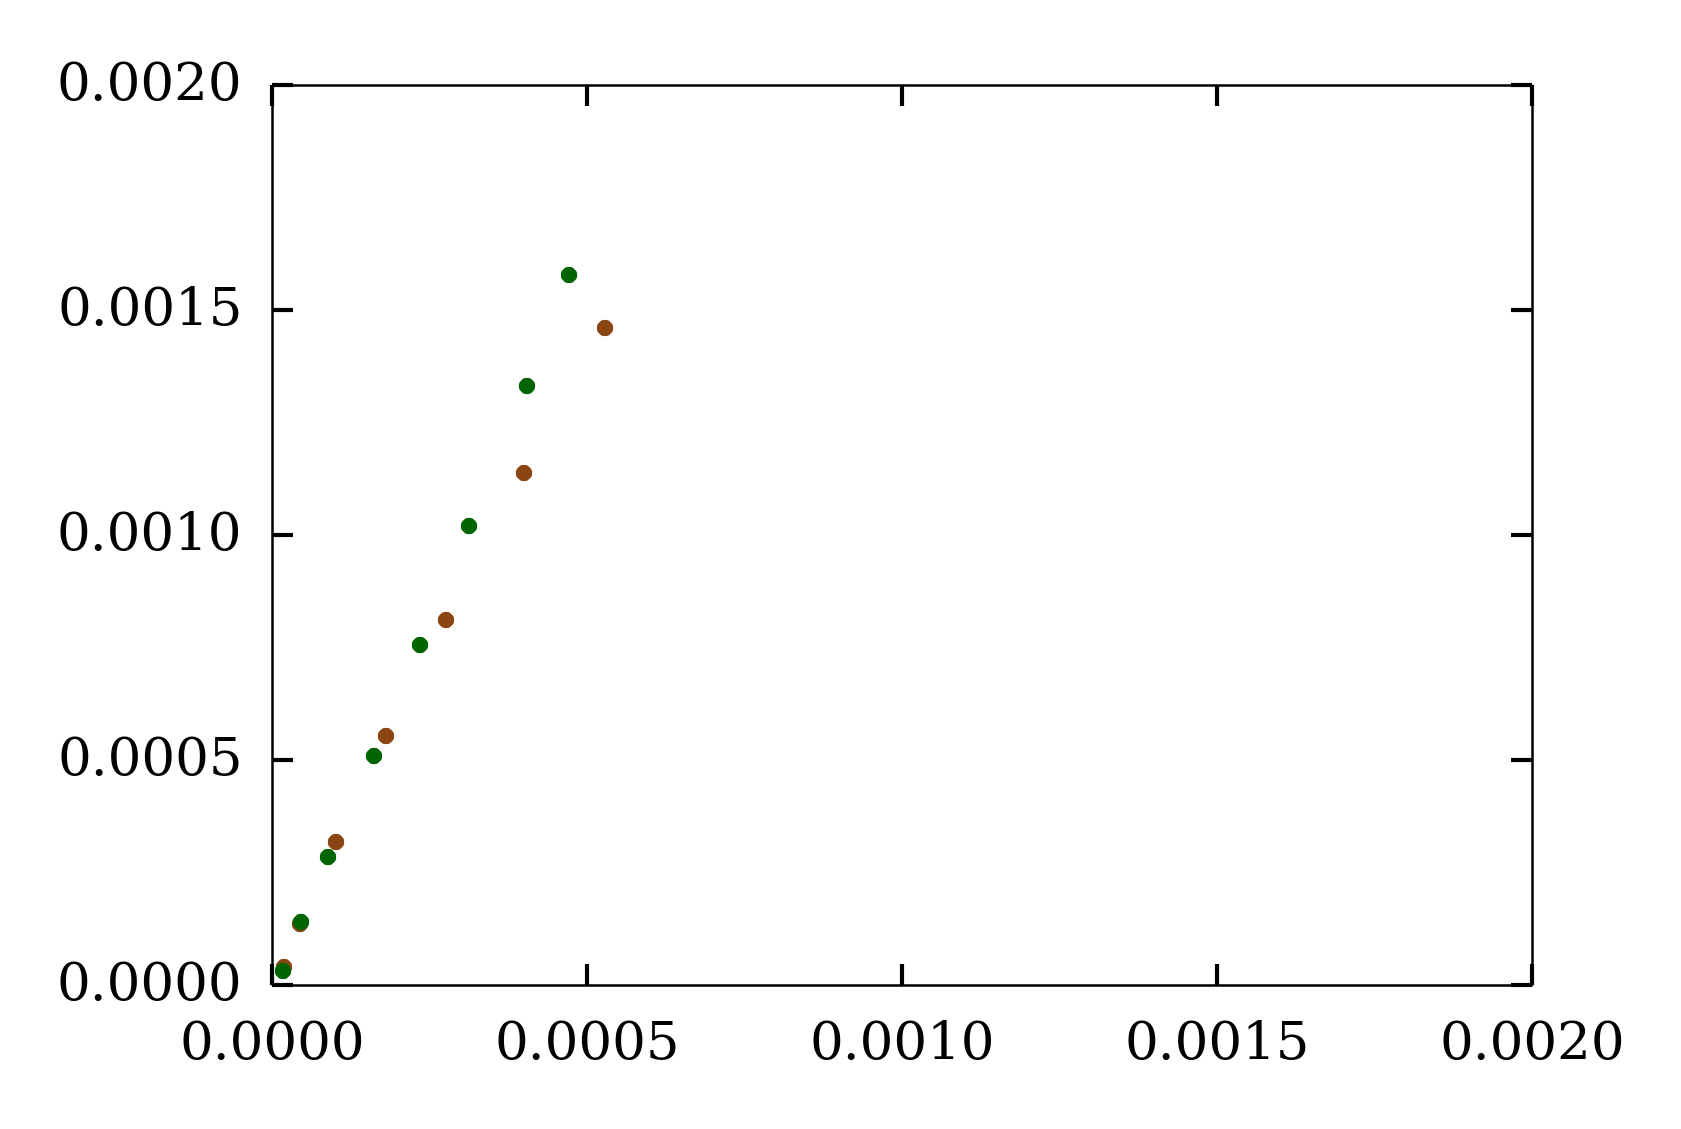

In [45]:
fig, ax = plt.subplots()

ax.plot(cw.source_power_X, cw.X * (cw.N_qp - cw.N_qp0), '.', color=cw_color)
ax.plot(bb.source_power_X, bb.X * (bb.N_qp - bb.N_qp0), '.', color=bb_color)
ax.set_xlim(0, 0.002)
ax.set_ylim(0, 0.002)

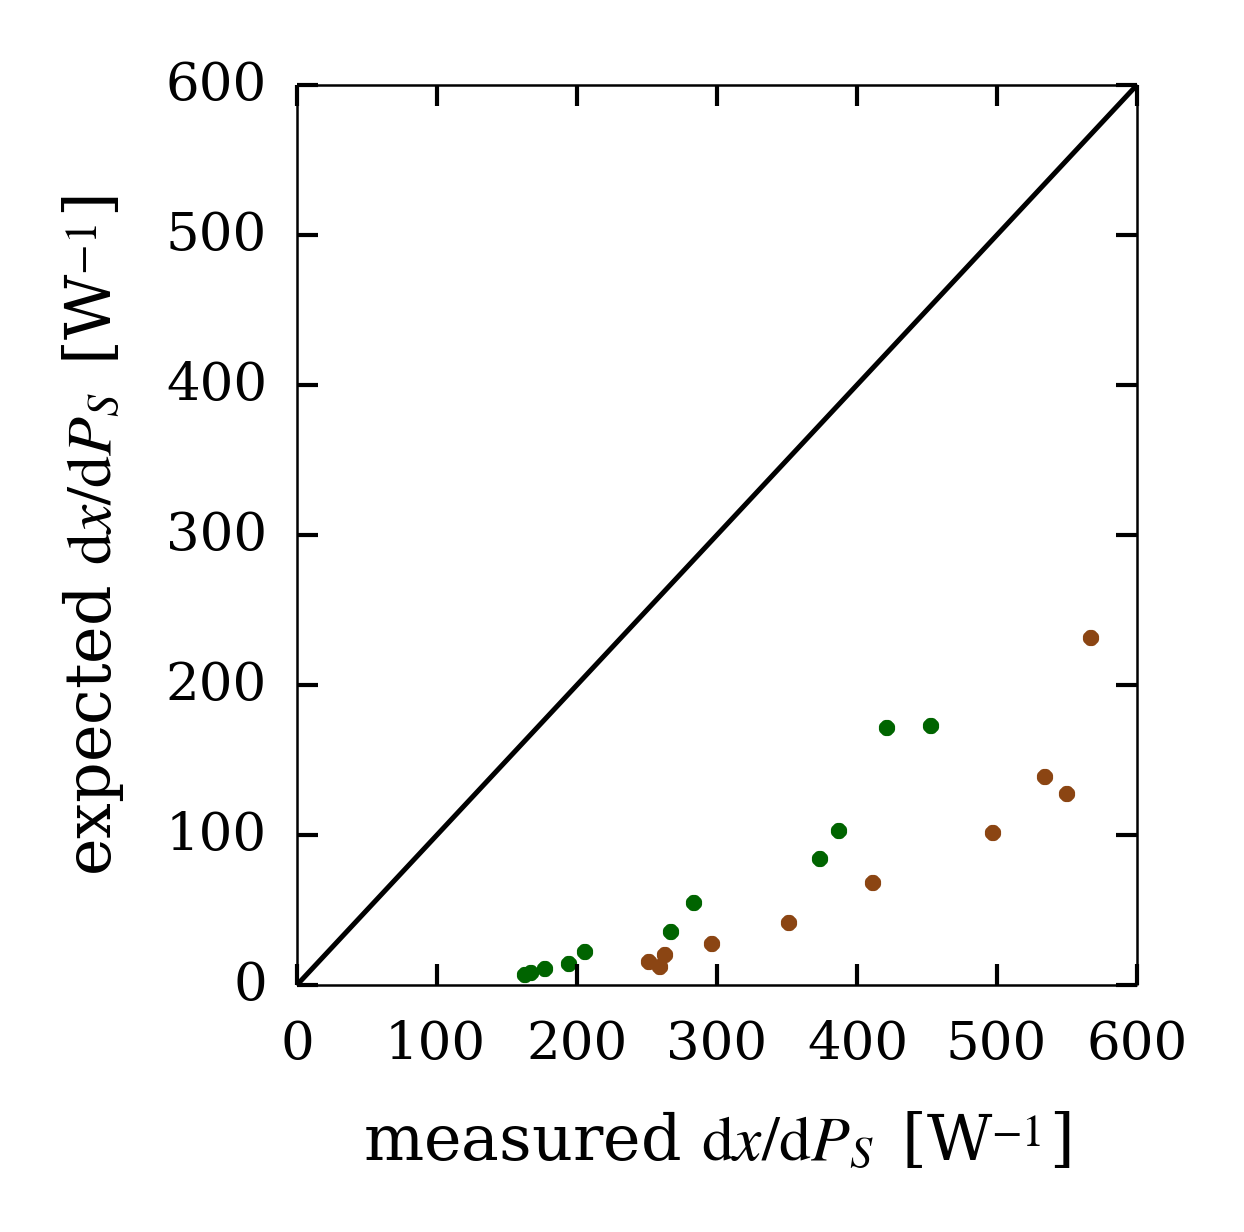

In [55]:
fig, ax = plt.subplots(figsize=(2, 2))

end = 600
ax.plot([0, end], [0, end], '-k')

ax.plot(2 * cw.X * cw.tau * cw.eta / (h * nu_cw),
        cw.source_power_fd_dX_dP,
        '.', color=cw_color)

ax.plot(2 * bb.X * bb.tau * bb.eta / (h * nu_bb),
        bb.source_power_fd_dX_dP,
        '.', color=bb_color)

ax.set_xlabel(r'measured $\mathrm{d} x / \mathrm{d} P_S$ [W$^{-1}$]')
ax.set_ylabel(r'expected $\mathrm{d} x / \mathrm{d} P_S$ [W$^{-1}$]')
ax.set_xlim(0, end)
ax.set_ylim(0, end);

We can remove the dependence on $\eta_S$ by calculating

\begin{align*}
\frac{P_S}{x} \frac{\mathrm{d} x}{\mathrm{d} P_S}
  &=
\end{align*}

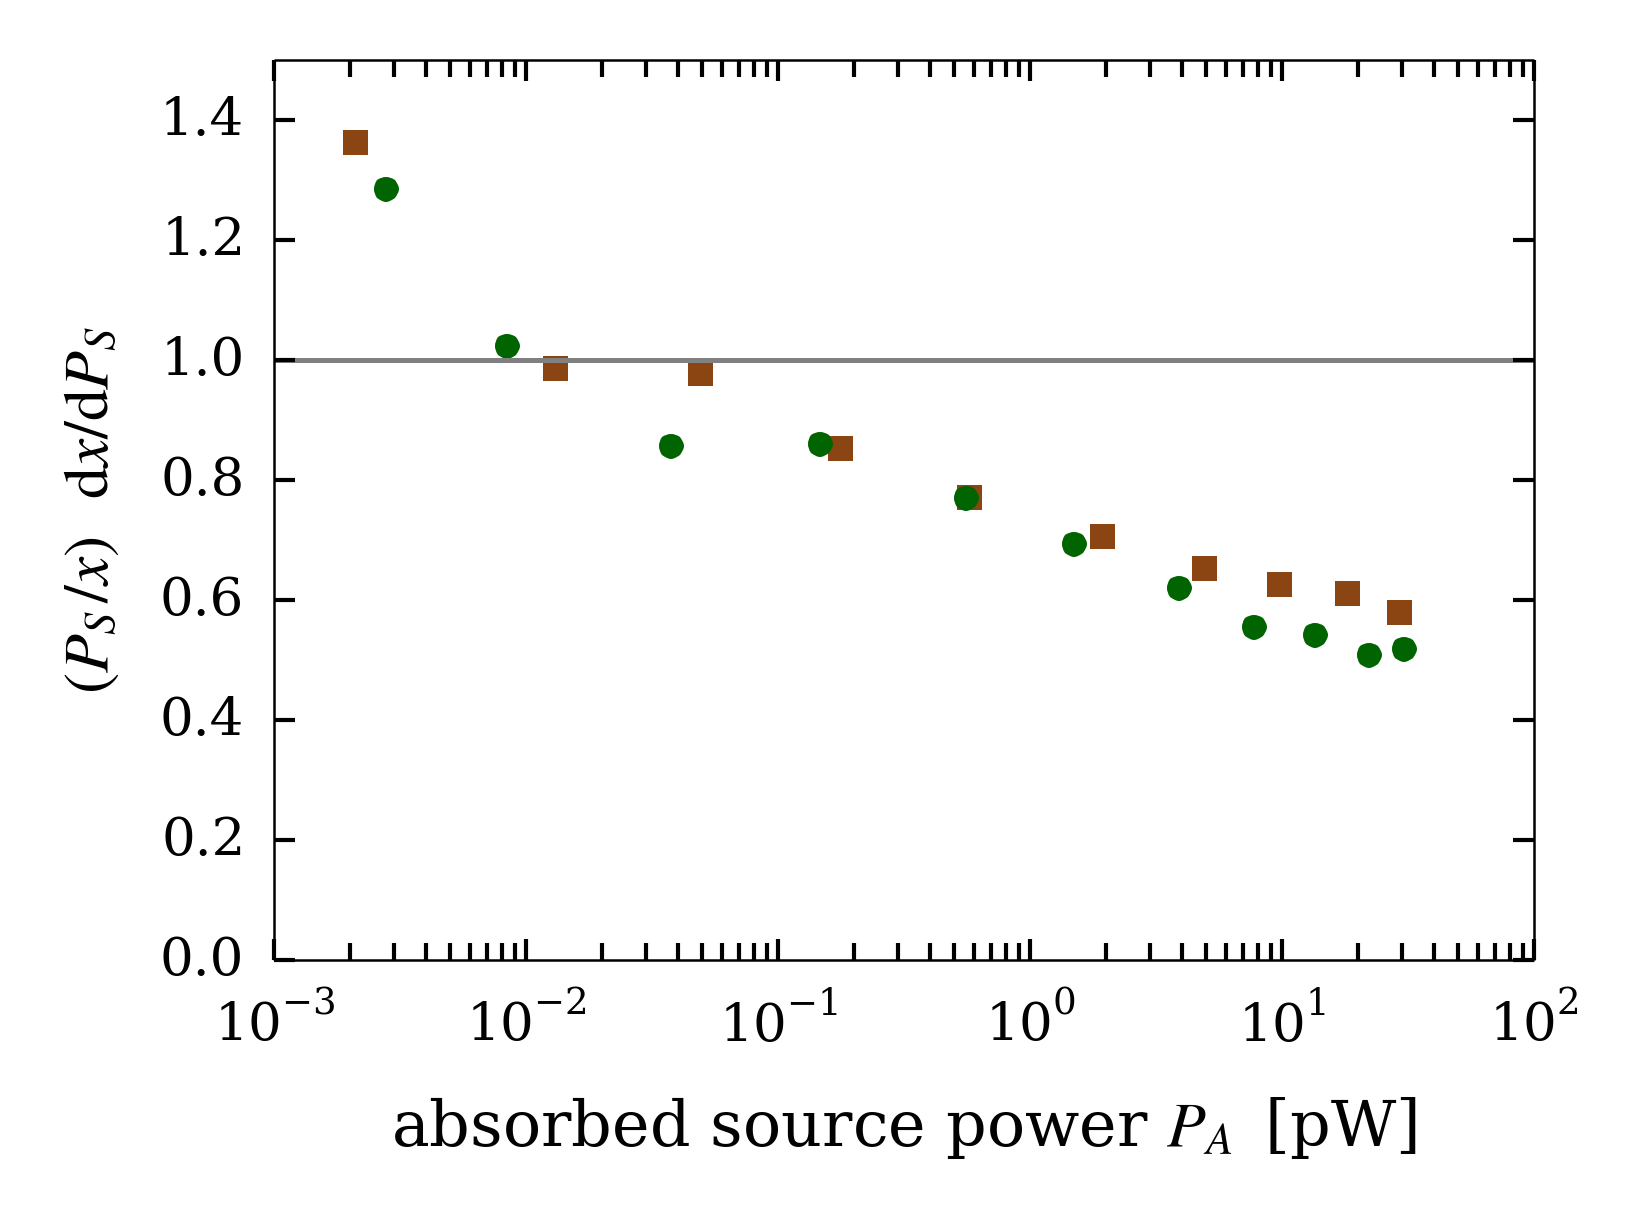

In [16]:
fig, ax = plt.subplots()

ax.semilogx(PA_scale * eta_cw * cw.source_power,
          (cw.source_power / cw.source_power_X) * cw.source_power_fd_dX_dP,
          color=cw_color, marker=cw_marker, markeredgecolor='none', linestyle='none')

#ax.loglog(PA_scale * eta_cw * cw.source_power,
#          1 / (eta_cw * cw.source_power),
#          '-', color=cw_color)

ax.semilogx(PA_scale * eta_bb * bb.source_power,
          (bb.source_power / bb.source_power_X) * bb.source_power_fd_dX_dP,
          color=bb_color, marker=bb_marker, markeredgecolor='none', linestyle='none')

#ax.loglog(PA_scale * eta_bb * bb.source_power,
#          1 / (eta_bb * bb.source_power),
#          '-', color=bb_color)

ax.legend(loc='best')
ax.set_xlabel(r'absorbed source power $P_A$ [pW]')
ax.set_ylabel(r'$(P_S / x) \; \mathrm{d} x / \mathrm{d} P_S$')
ax.axhline(1, color='gray')
ax.set_ylim(0, 1.5);

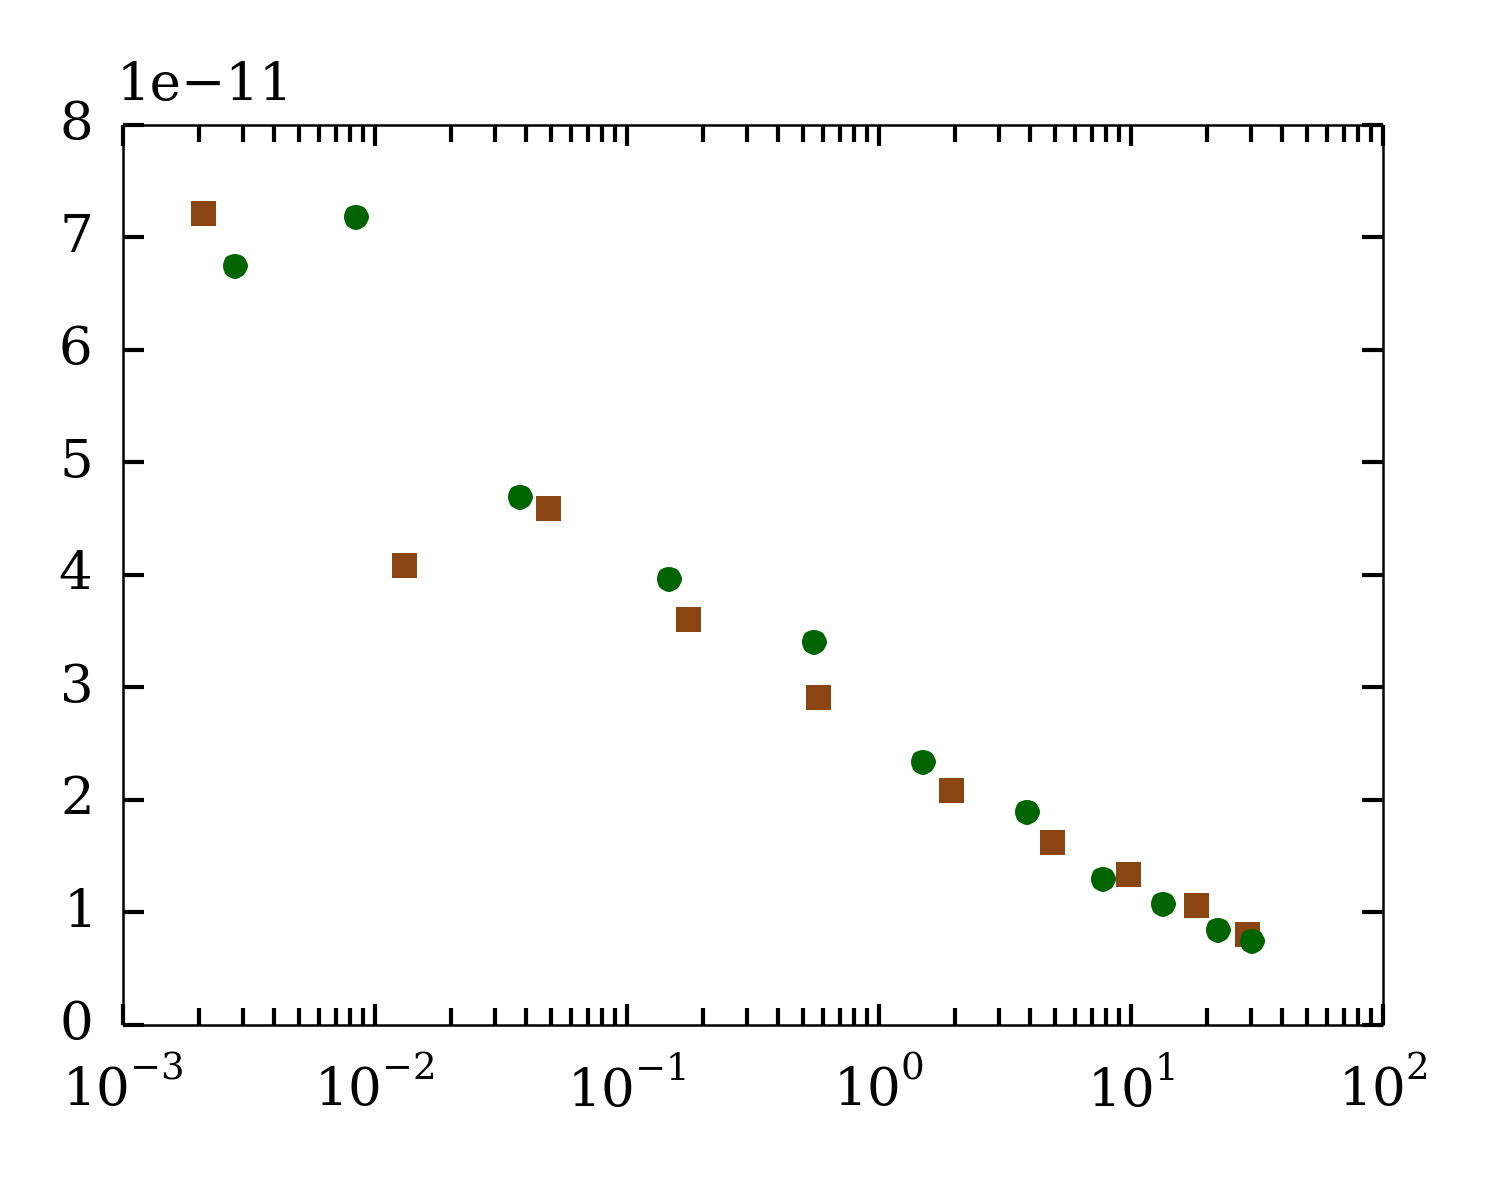

In [14]:
fig, ax = plt.subplots()

ax.semilogx(PA_scale * eta_cw * cw.source_power,
            (h * nu_cw) / (2 * cw.tau * eta_cw) * cw.source_power_fd_dX_dP,
            color=cw_color, marker=cw_marker, markeredgecolor='none', linestyle='none')

ax.semilogx(PA_scale * eta_bb * bb.source_power,
            (h * nu_bb) / (2 * bb.tau * eta_bb) * bb.source_power_fd_dX_dP,
            color=bb_color, marker=bb_marker, markeredgecolor='none', linestyle='none')


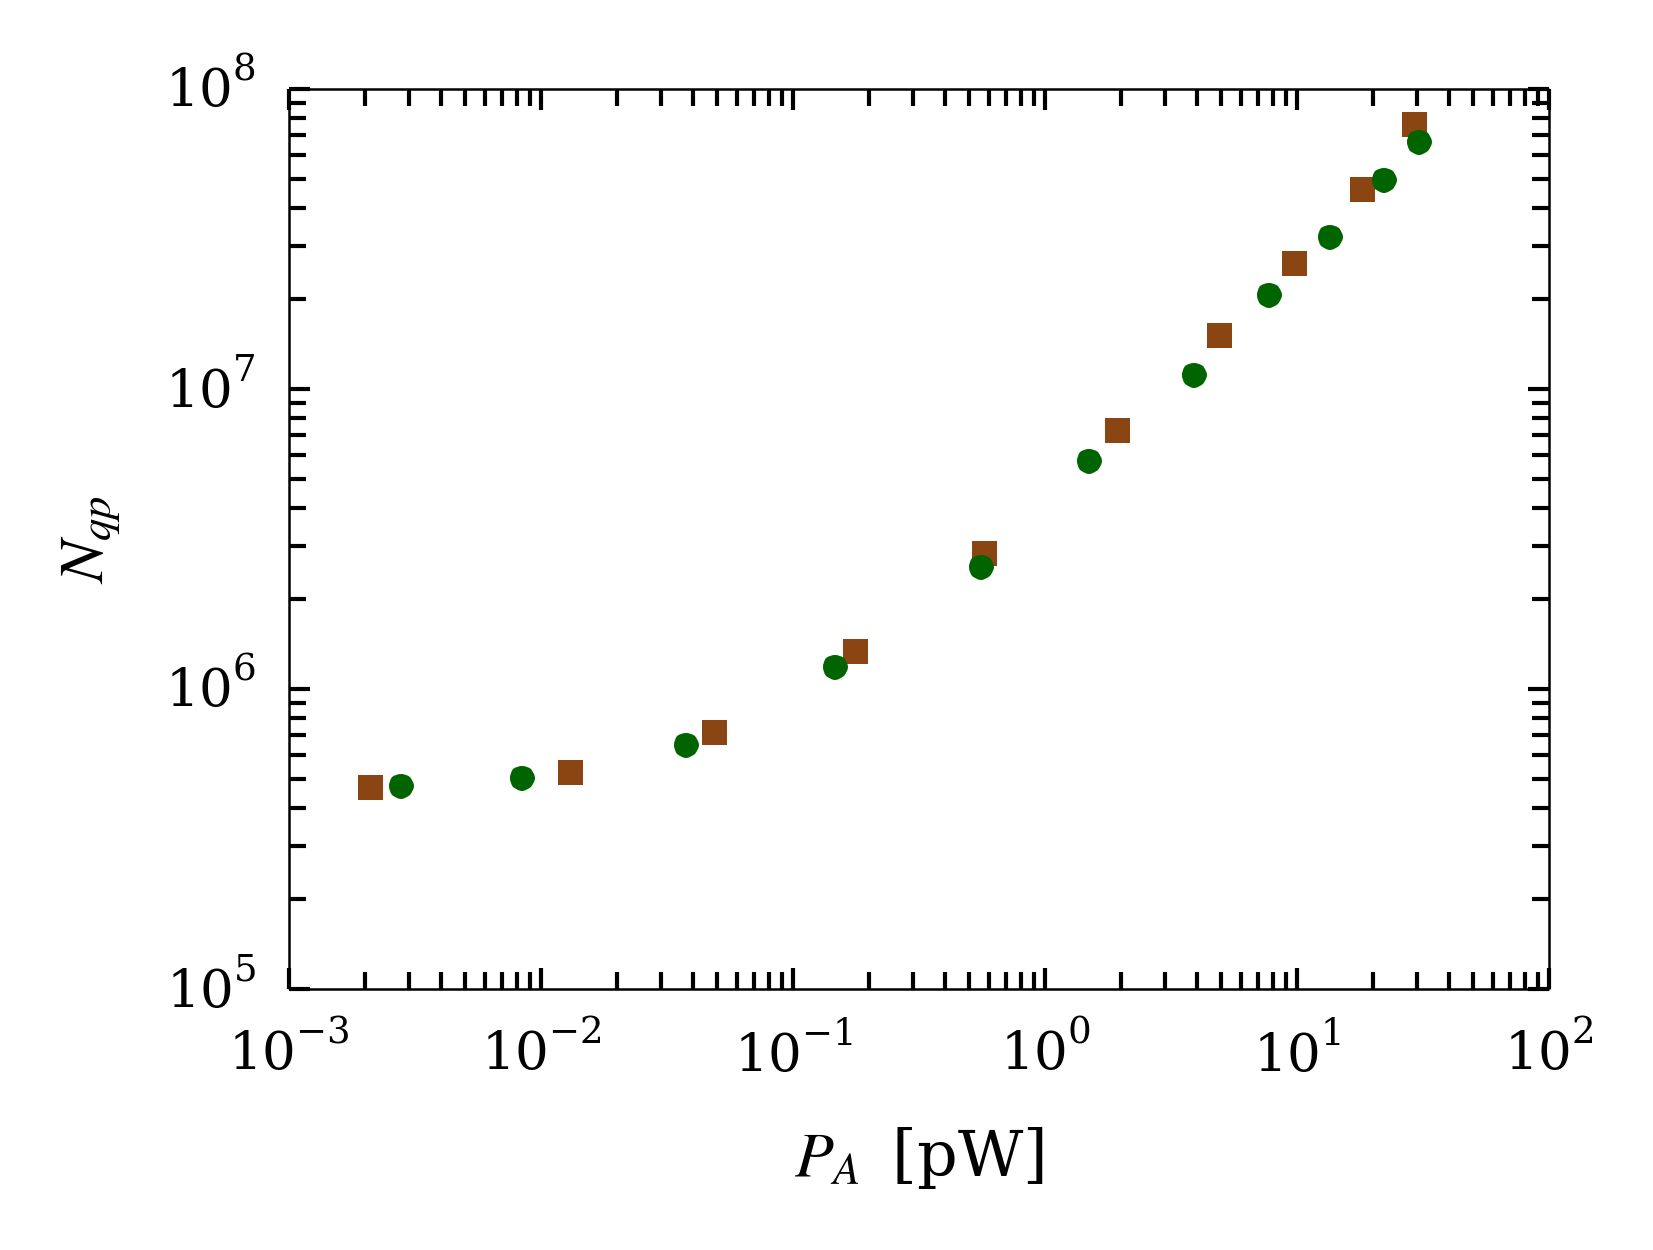

In [15]:
fig, ax = plt.subplots()

ax.plot(PA_scale * eta_cw * cw.source_power,
        N_qp0 + 4 * cw.tau * eta_cw * cw.source_power / (h * nu_cw),
        color=cw_color, marker=cw_marker, markeredgecolor='none', linestyle='none')

ax.plot(PA_scale * eta_bb * bb.source_power,
        N_qp0 + 4 * bb.tau * eta_bb * bb.source_power / (h * nu_bb),
        color=bb_color, marker=bb_marker, markeredgecolor='none', linestyle='none')

ax.set_xlabel('$P_A$ [pW]')
ax.set_ylabel('$N_{qp}$')
ax.set_xscale('log')
ax.set_yscale('log');
